In [1]:
import pandas as pd
from pandas import option_context

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Tuple, Dict, Union, Optional
import random
import glob
random.seed(0)
import dataframe_image as dfi
import re
from collections import Counter

from scipy.stats import normaltest, ttest_ind, tukey_hsd

from generation_exp import get_best_checkpoint

pd.set_option('max_colwidth', 400) # avoid trimming cells
pd.set_option('display.max_columns', None) # avoid truncating columns
pd.set_option('display.max_rows', None) # avoid truncating rows

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/cluster/tkew/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
exp_seeds = [23, 42, 1984]
resource_path = Path('resources/models')

plot_path = Path(f'resources/agg_results/plots')
plot_path.mkdir(parents=True, exist_ok=True)

### Inspect generated outputs

In [18]:
def parse_generations_file_stem(stem: str) -> Tuple:
    """
    generations_test_freq_seed=0_ml=40_lp=1.0_ns=1_bs=4_ds=1_temp=0.7_tk=0_tp=0.9.txt
    """
    parts = stem.split('_')
    gen_seed = int(parts[3].split('=')[-1])
    gen_setting = None
    if len(parts) == 12 and parts[-1] == 'tp=0.9':
        # ['generations', 'test', 'freq', 'seed=42', 'ml=40', 'lp=1.0', 'ns=1', 'bs=4', 'ds=1', 'temp=0.7', 'tk=0', 'tp=0.9']
        gen_setting = 'default'
    else:
        # 'xatt=5-dialog' -> 'xatt=5-dialog', 'ctxt=5-train', 'pos', 'sents-10' -> 'ctxt=5-train_pos_sents-10'
        gen_setting = '_'.join(parts[12:])
    return (gen_setting, gen_seed)
    
def quick_lc(file: Union[str, Path]) -> int:
    with open(file, 'rb') as f:
        return sum(1 for line in f)
    
def read_lines(file: Union[str, Path], line_indices: Optional[List[int]]=None) -> List[str]:
    lines = []
    with open(file, 'r', encoding='utf8') as f:
        for i, line in enumerate(f):
            if line_indices and i not in line_indices:
                pass
            else:
                lines.append(line.strip())
    return lines

def sample_line_indices(lc: int, n: int) -> List[int]:
    return random.sample(range(lc), n)
    
def get_outputs_dataframe(model_path: Path, sample_n: int = 10) -> pd.DataFrame:
    # checkpoint_dir = get_best_checkpoint(model_path)
    file_list = list((model_path / f'outputs').glob('generation*'))
    
    if sample_n > 0:
        expected_lc = quick_lc(file_list[0])
        sample_lines = sample_line_indices(expected_lc, sample_n)
        print(sample_lines)
    else:
        sample_lines = None
    
    d = {}
    for file in file_list:
        d[parse_generations_file_stem(file.stem)] = read_lines(file, sample_lines)
    # load dictionary into dataframe, splitting the key tuple into a multiIndex
    df = pd.DataFrame(d.values(), index=pd.MultiIndex.from_tuples(d.keys(), names=['gen_setting', 'seed']))
    df = df.sort_values(by=['gen_setting', 'seed'], ascending=True)
    return df

# model_path = Path('resources/models/seed_42/ft/bart_small_rndm')
# model_path = Path('resources/models/seed_42/ft/bart_small_rndm')
sampled_outputs = get_outputs_dataframe(model_path, sample_n=10)
sampled_outputs.head(10)

[7123, 2591, 7433, 53, 4315, 8201, 2927, 8317, 1743, 4889]


0  \
gen_setting               seed                                          
ctxt=1-train_questions-10 0                I agree. Do you know that?   
                          42          I'm not sure. Do you know that?   
                          284    I don't know that. Do you know that?   
                          983   I didn't know that. Do you know that?   
                          8630   I don't know that. Do you know that?   
ctxt=5-train_neg_sents-10 0                I agree. Do you know that?   
                          42                            I'm not sure.   
                          284                           I don't know.   
                          983                      I don't know that.   
                          8630                     I don't know that.   

                                                                              1  \
gen_setting               seed                                                    
ctxt=1-train_questions-10 0                     I don't know. Do you know that?   
                          42    I think it is a lot of money. Do you know that?   
                          284                   I'm not sure. Do you know that?   
                          983    I agree. I wonder if they have a lot of money.   
                          8630                              Yeah, I'm not sure.   
ctxt=5-train_neg_sents-10 0                I don't know that. Do you know that?   
                          42                                 I don't know that.   
                          284                        I agree. Do you know that?   
                          983              I don't know that. Do you know that?   
                          8630                       I agree. Do you know that?   

                                                                                               2  \
gen_setting               seed                                                                     
ctxt=1-train_questions-10 0     I'm not sure, I don't know that. Did you know that the internet?   
                          42                              I think that is a lot of the universe.   
                          284                        I agree. Did you know that is the universe?   
                          983                                      I think it is a lot of money.   
                          8630                                     I think it is a lot of money.   
ctxt=5-train_neg_sents-10 0                                                   I don't know that.   
                          42                                     I'm not sure. Do you know that?   
                          284                                                 I don't know that.   
                          983                                   I wonder if it is the same time.   
                          8630   I don't know that. Did you know that the universe is the ocean?   

                                                         3  \
gen_setting               seed                               
ctxt=1-train_questions-10 0      Yeah, I do not know that.   
                          42           I do not know that.   
                          284          I do not know that.   
                          983          I do not know that.   
                          8630  I agree. Do you know that?   
ctxt=5-train_neg_sents-10 0             I don't know that.   
                          42            I don't know that.   
                          284           I don't know that.   
                          983           I don't know that.   
                          8630  I agree. Do you know that?   

                                                                                                      4  \
gen_setting               seed                                                                            
ctxt=1-train_questions-10 0     I 

### Emprical analysis for question context controlled generation

In [30]:
INDEX_LEVELS = ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']

def get_all_results(exp_seed_runs=[23], resource_path=resource_path, results_dir='results_topchat_kgd_test_freq', build_dataframe=True):
    """
    given a list of experiment seeds and the resource path directory, gather up all the results csv files we can find
    """
    model_c = Counter()
    result_c = Counter()
    
    dfs = []
    for seed in exp_seed_runs:
        exp_dir = resource_path / f'seed_{seed}'
        model_names = [p.name for p in Path(exp_dir / 'ft').iterdir()]
        print(f'\nFound {len(model_names)} models for seed {seed}: {model_names}')
        model_c.update(model_names)
        
        results_path = exp_dir / results_dir
        if build_dataframe:
            result_file_list = list(results_path.glob(f'*.csv'))
            print(f'Found {len(result_file_list)} results files in corresponding results directory ({results_path})')
            result_c.update(map(str, result_file_list))
            df = load_results_dataframe(result_file_list, verbose=False)
            dfs.append(df)

    print('\nFound models for the following experiment runs:\n')
    print(model_c)
    
    # print('\nFound results for the following experiment runs:\n')
    # print(result_c)

    df = pd.concat(dfs, axis=0) if len(dfs) else None
    if df is not None:
        print(f'Dataframe has {len(df)} entries')

    return df
    
def parse_results_filepath(file: Path) -> Tuple:
    """parses information from results file name such as, e.g.
    - bart_base-qu_ctxt_aug1.csv
    - bart_small-SI_bart-qu_ctxt_aug5.csv 
    - bart_small-SI_mass-0.25-qu_ctxt_aug1.csv
    """
    exp_seed = int(file.parts[2].split('_')[-1])
    parts = file.stem.split('-')
    model, chkpt, pt_config, exp_setting, gen_setting = None, None, None, None, None
    # print(parts)
    # if len(parts) == 2:
    #     model, gen_setting = parts # bart_base-qu_ctxt_aug1.csv -> model name, generation setting
    if len(parts) == 3: # ['bart_base', 'best', 'xa_knowledge+qu_ctxt_aug5'] 
        model, chkpt, gen_setting = parts
    elif len(parts) == 4: # ['bart_small', 'MLM', 'best', 'baseline']
        model, pt_config, chkpt, gen_setting = parts
    else:
        raise RuntimeError(f'failed to parse file with: {parts}')

    if gen_setting == 'baseline': # rename baseline as default
        gen_setting = 'default'
        
    if not pt_config:
        pt_config = model
    else: # tidy up names
        pt_config = pt_config.replace('_bart5_25', '(BART5:25)')
        pt_config = pt_config.replace('_bart5_50', '(BART5:50)')
        pt_config = pt_config.replace('_bart5_75', '(BART5:75)')
        pt_config = pt_config.replace('_bart', '(BART)')
        pt_config = pt_config.replace('_t5', '(T5)')
        pt_config = pt_config.replace('_mass', '(MASS)')
        pt_config = pt_config.replace('_', '+')

    if chkpt and chkpt != 'best':
        chkpt = int(chkpt.split('_')[-1])
    
    ft_data_size = 1.0 # default values assumed
    if exp_setting is not None and exp_setting[0].isdigit():       
        ft_data_size = float(exp_setting)
    
    
    return exp_seed, pt_config, ft_data_size, chkpt, gen_setting    
        
def flatten(l: List[List]) -> List:
    """flattens a list of lists"""
    return [item for sublist in l for item in sublist]

def load_results_dataframe(result_file_list: List, verbose: bool = False) -> pd.DataFrame:
    
    dfs = []
    for file in result_file_list:    
        if verbose:
            print(f'Loading data from {file} ...')
        df = pd.read_csv(file, sep=',', header=0, index_col=None)
        df['exp_seed'], df['model'], df['ft_data_size'], df['chkpt'], df['gen_setting'] = parse_results_filepath(file)
        df['file'] = file.stem
        df = df.rename(columns={'self_bleu_t': 'self_bleu'}) # temp fix
        # if not any(df['seed'].isnull()):
        #     print(f"check seed in {file}. Found value of {df['seed']}")
        # df['gen_seed'] = df['seed'].astype('int32')
        dfs.append(df)

    df = pd.concat(dfs, axis=0).reset_index(drop=True)
    # standardise concatenated dataframe
    df.set_index(INDEX_LEVELS, inplace=True)
    df = df.sort_values(by=INDEX_LEVELS, ascending=True)
    
    if verbose:
        print(f'\nResults table contains:')
        for col_name in df.columns.to_list():
              print(f'\t{col_name}')
        print(f'Dataframe index:')
        print(f'\t{df.index}')
        print(f'Dataframe has {len(df)} entries')
    return df

df = get_all_results([23, 42, 1984], results_dir='results_topchat_kgd_test_freq_221102', build_dataframe=True)
df.head(8)


Found 38 models for seed 23: ['bart_small-SI_mass-squad_v2', 'bart_small-SI_bart5_50', 'bart_small-SI_t5-squad', 'bart_small_rndm', 'scratch', 'bart_small-SI_bart', 'bart_small-SI_t5-0.25', 'bart_small-MLM', 'bart_small-SI_PS', 'bart_small-SI_t5-squad_v2', 'bart_small-SI_t5-enc-squad', 'bart_small-SI_bart5_75', 'bart_small-SI_mass-0.75', 'bart_base', 'bart_small-SI_mass-0.25', 'bart_small-PS', 'bart_small-SI_bart-enc-squad', 'bart_small-MLM_PS', 'bart_small-SI_bart-0.75', 'bart_small-SI_bart-squad_v2', 't5_small', 't5_lm_small', 'bart_small-SI_t5-0.5', 'bart_small-SI_t5-0.75', 'bart_small-SI_mass-enc-squad', 'bart_small-MLM_PS_DR', 'bart_small-SI_mass-0.5', 'bart_small-SI_t5', 'bart_small-SI_mass-0.1', 'bart_small-SI_t5-0.1', 'bart_small-SI_bart-0.5', 'mass_base', 'bart_small-SI_mass-squad', 'bart_small-SI_bart5_25', 'bart_small-SI_bart-0.25', 'bart_small-SI_bart-0.1', 'bart_small-SI_mass', 'bart_small-SI_bart-squad']
Found 140 results files in corresponding results directory (resourc

model_name_or_path  \
exp_seed model gen_setting        chkpt ft_data_size seed                                               
23       MLM   default            best  1.0          0     resources/models/seed_23/ft/bart_small-MLM   
                                                     42    resources/models/seed_23/ft/bart_small-MLM   
                                                     284   resources/models/seed_23/ft/bart_small-MLM   
                                                     983   resources/models/seed_23/ft/bart_small-MLM   
                                                     8630  resources/models/seed_23/ft/bart_small-MLM   
               neg_sent_ctxt_aug5 best  1.0          0     resources/models/seed_23/ft/bart_small-MLM   
                                                     42    resources/models/seed_23/ft/bart_small-MLM   
                                                     284   resources/models/seed_23/ft/bart_small-MLM   

                                                           checkpoint_dir  \
exp_seed model gen_setting        chkpt ft_data_size seed                   
23       MLM   default            best  1.0          0                NaN   
                                                     42               NaN   
                                                     284              NaN   
                                                     983              NaN   
                                                     8630             NaN   
               neg_sent_ctxt_aug5 best  1.0          0                NaN   
                                                     42               NaN   
                                                     284              NaN   

                                                           batch_size  \
exp_seed model gen_setting        chkpt ft_data_size seed               
23       MLM   default            best  1.0          0            120   
                                                     42           120   
                                                     284          120   
                                                     983          120   
                                                     8630         120   
               neg_sent_ctxt_aug5 best  1.0          0            120   
                                                     42           120   
                                                     284          120   

                                                                                                test_file  \
exp_seed model gen_setting        chkpt ft_data_size seed                                                   
23       MLM   default            best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                     42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                     284   resources/data/Topical-Chat/KGD/test_freq.json   
                                                     983   resources/data/Topical-Chat/KGD/test_freq.json   
                                                     8630  resources/data/Topical-Chat/KGD/test_freq.json   
               neg_sent_ctxt_aug5 best  1.0          0     resources/data/Topical-Chat/KGD/test_freq.json   
                                                     42    resources/data/Topical-Chat/KGD/test_freq.json   
                                                     284   resources/data/Topical-Chat/KGD/test_freq.json   

                                                           data_seed  \
exp_seed model gen_setting        chkpt ft_data_size seed              
23       MLM   default            best  1.0          0             0   
                                                     42            0   
                                                     284           0   
                                                     983           0   
       

In [31]:
def get_detailed_info_on_complex_dataframe(df):
    
#     print('Index Columns:')
#     for name in df.index.names:
#         print(f'\t{df.index.get_level_values(name).unique()}')
#     print()
    
    print('Index columns value counts:\n')
    for name in df.index.names:
        print(f'{df.index.get_level_values(name).value_counts()}')
    print()

    print(f'Dataframe columns:')
    print(f'\t{df.columns}')
    print()
    return

get_detailed_info_on_complex_dataframe(df)

Index columns value counts:

23      700
42      700
1984    700
Name: exp_seed, dtype: int64
MLM                150
MLM+PS             150
MLM+PS+DR          150
PS                 150
SI(BART)           150
SI(BART5:25)       150
SI(BART5:50)       150
SI(BART5:75)       150
SI(MASS)           150
SI(T5)             150
bart_base          150
bart_small_rndm    150
t5_lm_small        150
t5_small           150
Name: model, dtype: int64
default                      210
neg_sent_ctxt_aug5           210
neu_sent_ctxt_aug5           210
pos_sent_ctxt_aug5           210
qu_ctxt_aug1                 210
qu_ctxt_aug5                 210
xa_dialog                    210
xa_dialog+qu_ctxt_aug5       210
xa_knowledge                 210
xa_knowledge+qu_ctxt_aug5    210
Name: gen_setting, dtype: int64
best    2100
Name: chkpt, dtype: int64
1.0    2100
Name: ft_data_size, dtype: int64
0       420
42      420
284     420
983     420
8630    420
Name: seed, dtype: int64

Dataframe columns:
	Index(

In [33]:
# # SI+PS is not available for all exp seeds, so drop it.
# df = df.drop('SI+PS', level=1, axis=0)
# # df = df.iloc[df.index.get_level_values('ft_data_size') == 1.0] # select only those entries which use 100% fine-tuning data
# # df = df[df.index.get_level_values('chkpt') == 'best']# select only those entries which use the best model (not checkpoints)
# get_detailed_info_on_complex_dataframe(df)

### generate tables highlighting metric differences

In [41]:
baselines_settings = list(set(['default', 'xa_dialog', 'xa_knowledge']))
print('BASELINES:', baselines_settings)
experiment_settings = list(set([key[2] for key in df.index if key[2] not in baselines_settings]))
print('EXPERIMENT SETTINGS:', experiment_settings)

def calculate_diffs(df, target, baseline):
    df.loc[target][:] = df.loc[target] - df.loc[baseline]
    return df

def highlight_max(s):
    return np.where(s == np.nanmax(s.to_numpy()), f"font-weight:bold;", None)

def style_nums(v):
    if v < 0:
        return 'color:red;'
    elif v > 0:
        return 'color:MediumSeaGreen;'
    else:
        return None

def style_dataframe(df, ignore=None):
    """formats a given dataframe with baseline rows and performance diff rows"""
    s = df.style # init style object from df

    # remove alternating row colors
    s.set_table_styles([
        {
            "selector":"thead",
            "props":[("background-color","white")]
        },
        {
            "selector":"tbody tr:nth-child(even)",
            "props":[("background-color","white")]
        },
    ])
    
    # grey out baseline rows border-bottom: 1px solid black;
    s.apply(lambda s: np.where(s.index.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    s.apply_index(lambda s: np.where(s.isin(baselines_settings), 'color:gray; border-top: 1px solid;', ''), axis=0)
    
    # color values (elementwise)
    s.applymap(style_nums, subset=(experiment_settings, slice(None)))


    # find max from each row
    s.apply(highlight_max, axis=1)
    
    # format numbers
    s.format(lambda x: f'{x*100:.2f}')

    if ignore is not None:
        s.hide(subset=ignore, axis=0, level=None, names=False)
    # format index names
#     s.format_index(lambda x: index_mapping.get(x), axis=1, na_rep='MISS')
    return s

def aggregate_values_for_target_metric(df, agg_ops: Dict = {'qc_sent_level': np.mean}):
    
    print(f'Dataframe has length: {len(df)}')
    
    if set(df.index.get_level_values('ft_data_size').values) != set([1.0]):
        print(f"[!] Found multiple fine-tuning data sizes: {set(df.index.get_level_values('ft_data_size').values)}")
    if set(df.index.get_level_values('chkpt').values) != set(['best']):
        print(f"[!] Found multiple checkpoint values: {set(df.index.get_level_values('chkpt').values)}")
               
    # aggregate values
    print(f'Dataframe has index columns: {df.index.names}')
    group_by_cols = ['model', 'gen_setting']
    print(f'Will group by: {group_by_cols}')
    df = df.groupby(group_by_cols, as_index=True).agg(agg_ops)

    # apply sorting
    df = df.sort_values(group_by_cols, ascending=[1]*len(group_by_cols))

    # apply filtering on rows (if necessary)
    # df = df.drop(['xa_dialog', 'xa_knowledge'], level=1, axis=0)
    # df = df.iloc[df.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
    # df = df.iloc[~df.index.get_level_values(0).str.contains('bart_small')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level

    return df

def reshape(df, subset: List = None):
    """
    reshape from vertical to horizontal format
    """
    df = df.stack().unstack(0)
    df = df.reset_index(level=1, drop=True) # remove the dummy index 'gen_setting'
    # dfa = dfa.droplevel(level=0, axis=1) # remove metric index (if necessary)
    # dfa.columns = dfa.columns.droplevel() # remove metric index (if necessary)

    if subset is not None:
        df = df[subset]
    # apply filtering on columns (if necessary)
#     keep_cols = ['MLM+PS', 'MLM-RW', 'MLM-RW(T5)', 'MLM-RW+PS']
#     drop_cols = [col for col in dfa.columns if col not in keep_cols]
#     dfa = dfa.drop(columns=drop_cols, errors='ignore')
    
    # reorder columns
    print('Dataframe has columns:', list(df.columns))
    all_reordered_cols = ['MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR', 
                          'SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)',
                          'bart_base', 't5_small', 't5_lm_small',
                          'SI(BART5:25)', 'SI(BART5:50)', 'SI(BART5:75)',
                          'bart_small_rndm',
                         ]
    avail_resorted_cols = []
    for col in all_reordered_cols:
        if col in set(list(df.columns)):
            avail_resorted_cols.append(col)
            
# #     if set(reordered_cols) != set(list(dfa.columns)):
#         print('DF columns doesn\'t match provided for resorting. Check the resorted columns!')
#     else:
    print('Sorting columns as:', avail_resorted_cols)
    df = df[avail_resorted_cols]
    
    return df 

# # compute customised dataframe with experimental row showing difference between experimental result and the baseline setting
def make_diff_df(df, ignore=None, do_style=True):
    df = calculate_diffs(df, 'qu_ctxt_aug1', 'default')
    df = calculate_diffs(df, 'qu_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'pos_sent_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'neu_sent_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'neg_sent_ctxt_aug5', 'default')
    df = calculate_diffs(df, 'xa_dialog+qu_ctxt_aug5', 'xa_dialog')
    df = calculate_diffs(df, 'xa_knowledge+qu_ctxt_aug5', 'xa_knowledge')
    
    # print(df.index)
    # if drop:
    #     df = df.drop(labels=ignore, axis=0)
    # print(df.index)

    if do_style:
        df = style_dataframe(df, ignore=ignore)
    
    return df


mini_bart_MLM = ['MLM+PS', 'MLM', 'PS', 'MLM+PS+DR', 'MLM+DR']
mini_bart = ['SI+PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)',]
# mini_roberta = ['roberta_small_shared', 'roberta_small']
public_enc_dec = ['bart_base', 't5_small', 't5_lm_small']
public_enc = ['bert_base', 'roberta_base', 'bert_base_shared', 'roberta_base_shared']

qdf = aggregate_values_for_target_metric(df, agg_ops={'qc_sent_level': np.mean})
qdf = reshape(qdf, subset=[
    'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',
    ]
)

qdf = make_diff_df(qdf, ignore=[
    'xa_dialog', 'xa_dialog+qu_ctxt_aug5', 'xa_knowledge', 'xa_knowledge+qu_ctxt_aug5', 'qu_ctxt_aug1',
    'neu_sent_ctxt_aug5', 'neg_sent_ctxt_aug5', 'pos_sent_ctxt_aug5',
    ])
qdf

BASELINES: ['xa_knowledge', 'default', 'xa_dialog']
EXPERIMENT SETTINGS: ['xa_knowledge+qu_ctxt_aug5', 'qu_ctxt_aug5', 'pos_sent_ctxt_aug5', 'qu_ctxt_aug1', 'neu_sent_ctxt_aug5', 'neg_sent_ctxt_aug5', 'xa_dialog+qu_ctxt_aug5']
Dataframe has length: 2100
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm']
Sorting columns as: ['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm']


model,MLM+PS,MLM,PS,SI(BART),SI(MASS),SI(T5),bart_small_rndm
gen_setting,,,,,,,
default,35.25,50.42,40.61,50.83,44.90,54.06,54.22
qu_ctxt_aug5,11.60,5.95,3.83,7.13,-5.44,-5.48,-6.04


In [45]:
print(qdf.to_latex(hrules=True, convert_css=True))

\begin{table}
\theadwhite
\tbody tr:nth-child(even)white
\begin{tabular}{lrrrrrrr}
\toprule
model & MLM+PS & MLM & PS & SI(BART) & SI(MASS) & SI(T5) & bart_small_rndm \\
gen_setting &  &  &  &  &  &  &  \\
\midrule
\color{gray} default & \color{gray} 35.25 & \color{gray} 50.42 & \color{gray} 40.61 & \color{gray} 50.83 & \color{gray} 44.90 & \color{gray} 54.06 & \color{gray} \bfseries 54.22 \\
qu_ctxt_aug5 & \color{MediumSeaGreen} \bfseries 11.60 & \color{MediumSeaGreen} 5.95 & \color{MediumSeaGreen} 3.83 & \color{MediumSeaGreen} 7.13 & \color{red} -5.44 & \color{red} -5.48 & \color{red} -6.04 \\
\bottomrule
\end{tabular}
\end{table}



In [47]:
sdf = aggregate_values_for_target_metric(df, agg_ops={'pos_sents': np.mean})
sdf = reshape(sdf, subset=[
    'MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm',
    ]
)
sdf = make_diff_df(sdf, ignore=[
    'xa_dialog', 'xa_dialog+qu_ctxt_aug5', 'xa_knowledge', 'xa_knowledge+qu_ctxt_aug5', 'qu_ctxt_aug1', 'qu_ctxt_aug5',
    'neg_sent_ctxt_aug5', 'neu_sent_ctxt_aug5',
    ])
sdf

Dataframe has length: 2100
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']
Dataframe has columns: ['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm']
Sorting columns as: ['MLM+PS', 'MLM', 'PS', 'SI(BART)', 'SI(MASS)', 'SI(T5)', 'bart_small_rndm']


model,MLM+PS,MLM,PS,SI(BART),SI(MASS),SI(T5),bart_small_rndm
gen_setting,,,,,,,
default,47.60,41.97,42.90,44.04,46.44,45.96,27.21
pos_sent_ctxt_aug5,-10.69,-5.75,-11.73,-7.81,-12.14,2.03,17.17


In [48]:
print(sdf.to_latex(hrules=True, convert_css=True))

\begin{table}
\theadwhite
\tbody tr:nth-child(even)white
\begin{tabular}{lrrrrrrr}
\toprule
model & MLM+PS & MLM & PS & SI(BART) & SI(MASS) & SI(T5) & bart_small_rndm \\
gen_setting &  &  &  &  &  &  &  \\
\midrule
\color{gray} default & \color{gray} \bfseries 47.60 & \color{gray} 41.97 & \color{gray} 42.90 & \color{gray} 44.04 & \color{gray} 46.44 & \color{gray} 45.96 & \color{gray} 27.21 \\
pos_sent_ctxt_aug5 & \color{red} -10.69 & \color{red} -5.75 & \color{red} -11.73 & \color{red} -7.81 & \color{red} -12.14 & \color{MediumSeaGreen} 2.03 & \color{MediumSeaGreen} \bfseries 17.17 \\
\bottomrule
\end{tabular}
\end{table}



## Statistical Significance

In [61]:
# adapted from https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/

def check_is_normal(array, threshold=0.05):
    value, p = normaltest(array)
    if p >= 0.05:
        print(f'It is likely that {array} is normal')
    else:
        print(f'It is unlikely that {array} is normal')

def run_tests(values1, values2, threshold=0.05):
    """
    Following Hazarika et al., 2022 (https://arxiv.org/abs/2106.06411),
    we compute Two-tailed unpaired t-test and Tukey's HSD between 
    baseline (default generation) and experimental settings (e.g. with CTX. AUG.)
    """
    # print(values1.shape)
    # print(values2.shape)
    # check_is_normal(values1)
    # check_is_normal(values2)

    # print('Comparing Means for Gaussian Results...')
    
    value, pvalue = ttest_ind(values1, values2, equal_var=True)
    print(f"Two-tailed unpaired t-test: {value}, {pvalue}")
    if pvalue > threshold:
        print(f'\tSamples are likely drawn from the same distributions (fail to reject H0) p={threshold}')
    else:
        print(f'\tSamples are likely drawn from DIFFERENT distributions (reject H0) p={threshold} ***')
    
    # # Welch’s t-test (different variances)
    # value, pvalue = ttest_ind(values1, values2, equal_var=False)
    # print(f"Welch's t-test (unequal variances): {value}, {pvalue}")
    # if pvalue > threshold:
    #     print(f'\tSamples are likely drawn from the same distributions (fail to reject H0) p={threshold}')
    # else:
    #     print(f'\tSamples are likely drawn from different distributions (reject H0) p={threshold}')

    # non-Gaussian data
    # value, pvalue = ks_2samp(values1, values2)
    # print(value, pvalue)
    # if pvalue > 0.05:
    #     print('Samples are likely drawn from the same distributions (fail to reject H0)')
    # else:
    #     print('Samples are likely drawn from different distributions (reject H0)')

    # print(tukey_hsd(values1, values2))
    tuk = tukey_hsd(values1, values2)
    # print(dir(tuk))
    # print(tuk.confidence_interval())
    value = tuk.statistic[0,1]
    pvalue = tuk.pvalue[0,1]

    print(f"Tukey's HSD: {value}, {pvalue})")
    if pvalue > threshold:
        print(f'\tSamples are likely drawn from the same distributions (fail to reject H0) p={threshold}')
    else:
        print(f'\tSamples are likely drawn from DIFFERENT distributions (reject H0) p={threshold} ***')
    

def compute_significance(df, baseline_setting = "default", exp_setting = "qu_ctxt_aug5", tgt_metric = "qc_turn_level", threshold=0.05):
    
    exp_seeds = df.index.unique(level=0)
    models = df.index.unique(level=1)
    
    for model in models:
        print()
        for exp_seed in exp_seeds:
            print(f"Model: {model}, Seed run: {exp_seed}")
            bsl = df.iloc[(df.index.get_level_values(0) == exp_seed) & (df.index.get_level_values(1) == model) & (df.index.get_level_values(2) == baseline_setting)][tgt_metric].to_numpy()
            exp = df.iloc[(df.index.get_level_values(0) == exp_seed) & (df.index.get_level_values(1) == model) & (df.index.get_level_values(2) == exp_setting)][tgt_metric].to_numpy()    
            run_tests(bsl, exp, threshold=threshold)

    return
    
compute_significance(df, "default", "qu_ctxt_aug5", threshold=0.001)




Model: MLM, Seed run: 23
Two-tailed unpaired t-test: 8.424534524523404, 3.0040841304839183e-05
	Samples are likely drawn from DIFFERENT distributions (reject H0) p=0.001 ***
Tukey's HSD: 0.0151571980143409, 3.004084130542317e-05)
	Samples are likely drawn from DIFFERENT distributions (reject H0) p=0.001 ***
Model: MLM, Seed run: 42
Two-tailed unpaired t-test: -35.453230347474594, 4.3858277192797156e-10
	Samples are likely drawn from DIFFERENT distributions (reject H0) p=0.001 ***
Tukey's HSD: -0.09756205184776623, 4.3858272569252676e-10)
	Samples are likely drawn from DIFFERENT distributions (reject H0) p=0.001 ***
Model: MLM, Seed run: 1984
Two-tailed unpaired t-test: -26.6949490037101, 4.171860172361443e-09
	Samples are likely drawn from DIFFERENT distributions (reject H0) p=0.001 ***
Tukey's HSD: -0.09592939878654178, 4.171860079615897e-09)
	Samples are likely drawn from DIFFERENT distributions (reject H0) p=0.001 ***

Model: MLM+PS, Seed run: 23
Two-tailed unpaired t-test: -76.768

## Plots

In [131]:
name_mapping = {
    'gen_setting': 'Generation Setting',
    'bart_base': 'BART-base',
    't5_small': 'T5-small',
    't5_lm_small': 'T5-small-LM',
    'model': 'Model',
    'qc_turn_level': '% of inquisitive responses',
    'default': 'Default', 
    'qu_ctxt_aug1': 'CTX. AUG. + ATTN. BIAS = 1', 
    'qu_ctxt_aug5': 'CTX. AUG.',
    'pos_sent_ctxt_aug5': 'CTX. AUG.',
    'neg_sent_ctxt_aug5': 'CTX. AUG.',
    'neu_sent_ctxt_aug5': 'CTX. AUG.',
    'pos_sents': '% of positive responses',
    'neg_sents': '% of negative responses',
    'neu_sents': '% of neutral responses',
    'SI(BART)': "$\mathregular{SI_{BART}}$",
    'SI(MASS)': "$\mathregular{SI_{MASS}}$",
    'SI(T5)': "$\mathregular{SI_{T5}}$",
    'bart_small_rndm': "No PT",
    'rouge1_s': 'ROUGE-1 (src)',
    'bleu_t': 'BLEU',
    'ppl_mean': 'PPL',
    "intra_dist1": "Dist-1 (intra)",
    "inter_dist1": "Dist-1 (inter)",
    "self_bleu": "Self-BLEU",
    "bleu_t": "BLEU",
    "rouge1_t": "ROUGE-1",
    "rouge2_t": "ROUGE-2",
    "rougeL_t": "ROUGE-L",
    "meteor_t": "METEOR",
    "novelty_s_1gram": "% novel N-grams",
    "uniq": "% unique responses",
}

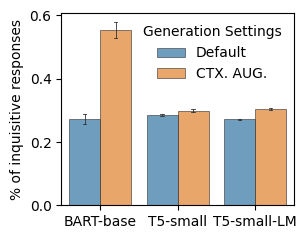

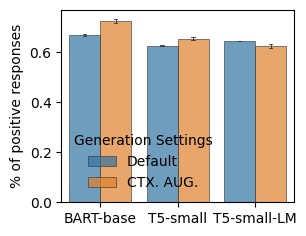

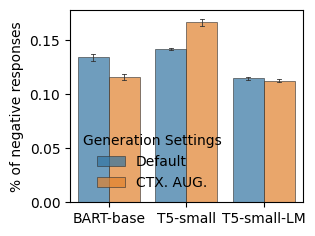

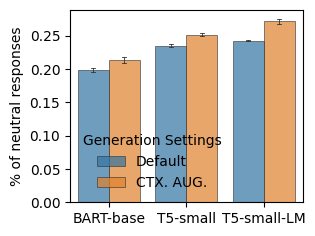

In [138]:
def contrastive_gen_settings_barplot(df, models, gen_settings, tgt_metric, save_as=None): #data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):

    # setup figure, axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.5))
    
    # subset dataframe
    dfs = df.iloc[(df.index.get_level_values(1).isin(models)) & (df.index.get_level_values(2).isin(gen_settings))].reset_index()
    # dfs.head()
    # print(len(dfs))

    sns.barplot(
        data=dfs, 
        x="model", 
        y=tgt_metric, 
        hue="gen_setting", 
        order=models, 
        hue_order=gen_settings,
        alpha=0.7, 
        capsize=.05,
        errwidth=0.6,
        errcolor=".2",
        linewidth=0.6, 
        edgecolor=".2", 
        palette='tab10',
        ax=ax,
    )
    
    # make plot pretty
    ax.set(xlabel=None, ylabel=name_mapping.get(tgt_metric, tgt_metric), title=None)

    labels = [name_mapping.get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()] # https://stackoverflow.com/questions/11244514/modify-tick-label-text
    ax.set_xticklabels(labels)

    
    # make legend pretty
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        labels = [name_mapping.get(label, label) for label in labels]
        ax.legend(handles, labels, title="Generation Settings", frameon=False)
    
    if save_as is not None:
        print('fsaving to {save_as}.* ...')
        plt.savefig(save_as+'.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(save_as+'.png', bbox_inches='tight', dpi=300)

    return

subset_models = ['bart_base', 't5_small', 't5_lm_small']
subset_gen_settings = ['default', 'qu_ctxt_aug5']
contrastive_gen_settings_barplot(df, subset_models, subset_gen_settings, tgt_metric="qc_turn_level")
contrastive_gen_settings_barplot(df, subset_models, ['default', 'pos_sent_ctxt_aug5'], tgt_metric="pos_sents")
contrastive_gen_settings_barplot(df, subset_models, ['default', 'neg_sent_ctxt_aug5'], tgt_metric="neg_sents")
contrastive_gen_settings_barplot(df, subset_models, ['default', 'neu_sent_ctxt_aug5'], tgt_metric="neu_sents")
# contrastive_gen_settings_barplot(df, subset_models, subset_gen_settings, save_as='resources/plots/public_models_qc')


---
# Performance metrics

In [162]:
perf_metrics = {
    'uniq': np.mean,
    'ppl_mean': np.mean,
    'intra_dist1': np.mean,
    'inter_dist1': np.mean,
    'self_bleu': np.mean,
    'bleu_t': np.mean,
    'rouge1_t': np.mean,
    'rouge2_t': np.mean,
    'rougeL_t': np.mean,
    'meteor_t': np.mean,
    'novelty_s_1gram': np.mean,
    # 'novelty_s_2gram': np.mean,
    # 'novelty_s_3gram': np.mean,
    # 'novelty_s_4gram': np.mean,
}
    
# produce table    
pdf = aggregate_values_for_target_metric(df[df.index.get_level_values(2) == 'default'], agg_ops=perf_metrics)
pdf = pdf.stack().unstack(0)
pdf = pdf.reset_index(level=0, drop=True)
pdf.drop(columns=[
    'MLM',
    # 'MLM+PS', # default bart
    'MLM+PS+DR','PS', # exp. bart metrics
    'SI(BART5:25)','SI(BART5:50)','SI(BART5:75)', # mixed obj
    # 'bart_small_rndm', # no pre-training
    'bart_base', 't5_lm_small', 't5_small' # public models
    ],
    inplace=True)
pdf

Dataframe has length: 210
Dataframe has index columns: ['exp_seed', 'model', 'gen_setting', 'chkpt', 'ft_data_size', 'seed']
Will group by: ['model', 'gen_setting']


model,MLM+PS,SI(BART),SI(MASS),SI(T5),bart_small_rndm
uniq,0.764979,0.681515,0.701114,0.702798,0.573083
ppl_mean,59.090450,53.712539,60.619647,58.639697,50.873901
intra_dist1,0.922566,0.927132,0.920619,0.928778,0.905299
inter_dist1,0.019852,0.017378,0.015457,0.016906,0.007675
self_bleu,74.396769,78.542067,77.935644,78.350147,85.633616
bleu_t,3.205001,3.287186,2.933111,3.570238,1.070371
rouge1_t,0.203521,0.205613,0.201582,0.212435,0.164463
rouge2_t,0.063359,0.064687,0.061079,0.067214,0.032436
rougeL_t,0.173279,0.174691,0.172121,0.180402,0.139131
meteor_t,0.151103,0.153729,0.147571,0.159609,0.106992


In [163]:
def contrastive_model_barplot(df, models, gen_setting, tgt_metric, save_as=None): #data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):

    # setup figure, axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 1.5))
    
    # subset dataframe
    dfs = df.iloc[(df.index.get_level_values(1).isin(models)) & (df.index.get_level_values(2) == gen_setting)].reset_index()

    sns.barplot(
        data=dfs, 
        x="model", 
        y=tgt_metric, 
        order=models, 
        hue_order=models,
        alpha=0.7, 
        capsize=.05,
        errwidth=0.6,
        errcolor=".2",
        linewidth=0.6, 
        edgecolor=".2", 
        palette='tab10',
        ax=ax,
    )
    
    # make plot pretty
    ax.set(xlabel=None, ylabel=None, title=name_mapping.get(tgt_metric, tgt_metric))

    labels = [name_mapping.get(item.get_text(), item.get_text()) for item in ax.get_xticklabels()] # https://stackoverflow.com/questions/11244514/modify-tick-label-text
    ax.set_xticklabels(labels)

    
    # make legend pretty
    handles, labels = ax.get_legend_handles_labels()
    if labels:
        labels = [name_mapping.get(label, label) for label in labels]
        ax.legend(handles, labels, title="Generation Settings", frameon=False)
    
    if save_as is not None:
        print(f'saving to {save_as}_{tgt_metric}.* ...')
        plt.savefig(f'{save_as}_{gen_setting}_{tgt_metric}.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(f'{save_as}_{gen_setting}_{tgt_metric}.png', bbox_inches='tight', dpi=300)

    return

saving to resources/plots/public_models_uniq.* ...
saving to resources/plots/public_models_ppl_mean.* ...
saving to resources/plots/public_models_intra_dist1.* ...
saving to resources/plots/public_models_inter_dist1.* ...
saving to resources/plots/public_models_self_bleu.* ...
saving to resources/plots/public_models_bleu_t.* ...
saving to resources/plots/public_models_rouge1_t.* ...
saving to resources/plots/public_models_rouge2_t.* ...
saving to resources/plots/public_models_rougeL_t.* ...
saving to resources/plots/public_models_meteor_t.* ...
saving to resources/plots/public_models_novelty_s_1gram.* ...


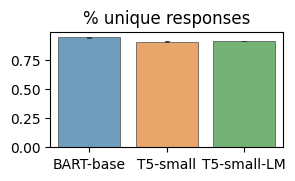

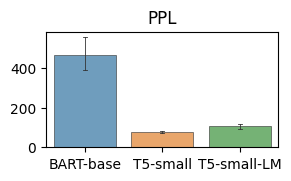

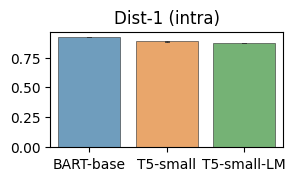

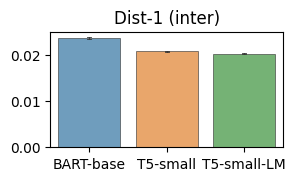

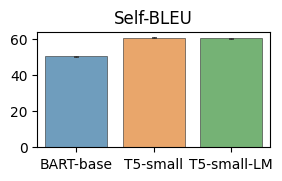

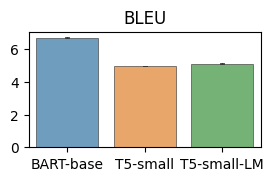

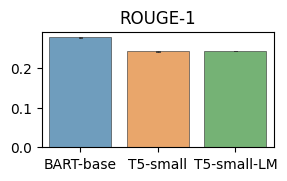

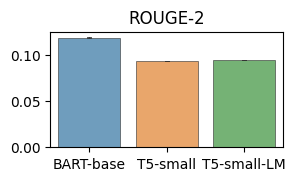

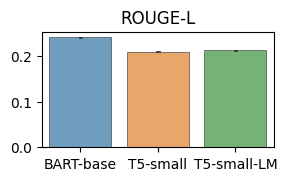

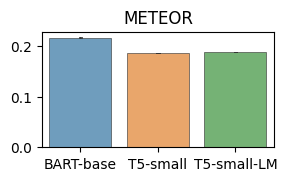

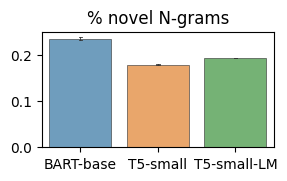

In [164]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(df, ['bart_base', 't5_small', 't5_lm_small'], 'default', tgt_metric=metric, save_as="resources/plots/public_models")

saving to resources/plots/bart_small_uniq.* ...
saving to resources/plots/bart_small_ppl_mean.* ...
saving to resources/plots/bart_small_intra_dist1.* ...
saving to resources/plots/bart_small_inter_dist1.* ...
saving to resources/plots/bart_small_self_bleu.* ...
saving to resources/plots/bart_small_bleu_t.* ...
saving to resources/plots/bart_small_rouge1_t.* ...
saving to resources/plots/bart_small_rouge2_t.* ...
saving to resources/plots/bart_small_rougeL_t.* ...
saving to resources/plots/bart_small_meteor_t.* ...
saving to resources/plots/bart_small_novelty_s_1gram.* ...


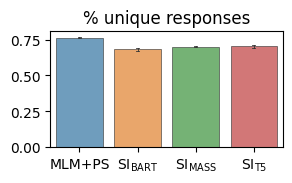

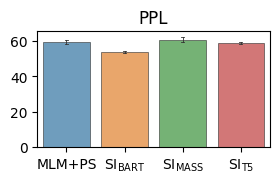

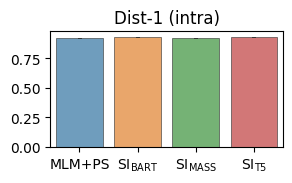

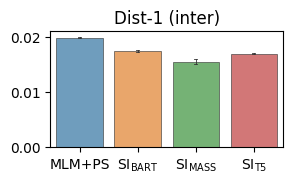

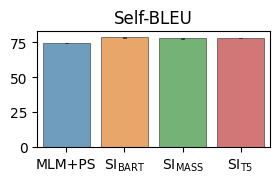

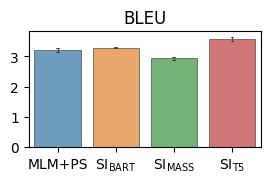

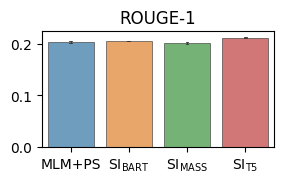

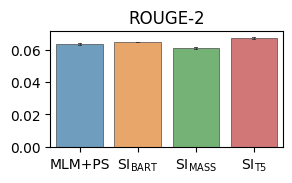

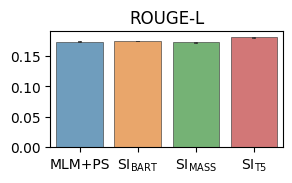

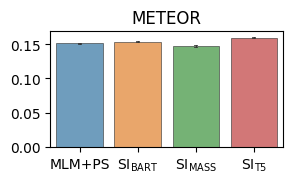

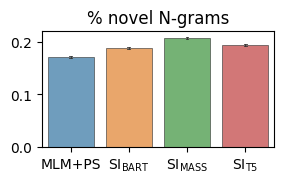

In [165]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(df, ['MLM+PS','SI(BART)', 'SI(MASS)', 'SI(T5)'], 'default', tgt_metric=metric, save_as="resources/plots/bart_small")

saving to resources/plots/bart_small_uniq.* ...
saving to resources/plots/bart_small_ppl_mean.* ...
saving to resources/plots/bart_small_intra_dist1.* ...
saving to resources/plots/bart_small_inter_dist1.* ...
saving to resources/plots/bart_small_self_bleu.* ...
saving to resources/plots/bart_small_bleu_t.* ...
saving to resources/plots/bart_small_rouge1_t.* ...
saving to resources/plots/bart_small_rouge2_t.* ...
saving to resources/plots/bart_small_rougeL_t.* ...
saving to resources/plots/bart_small_meteor_t.* ...
saving to resources/plots/bart_small_novelty_s_1gram.* ...


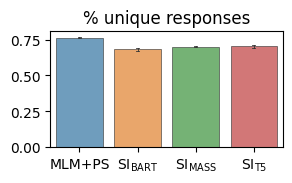

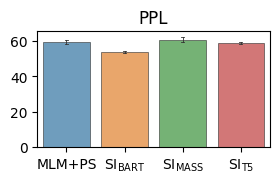

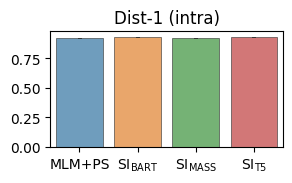

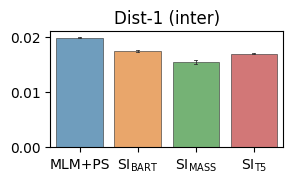

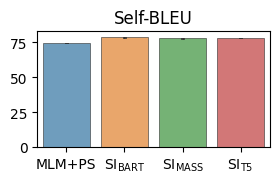

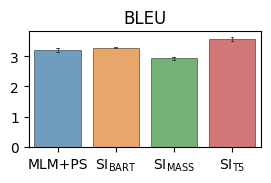

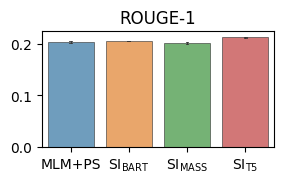

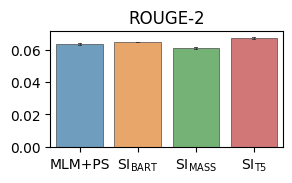

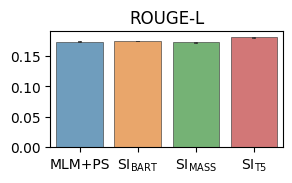

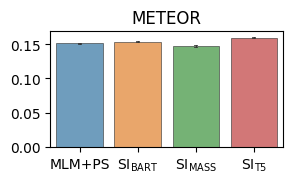

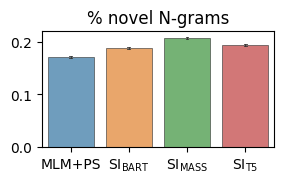

In [167]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(df, ['MLM+PS','SI(BART)', 'SI(MASS)', 'SI(T5)'], 'default', tgt_metric=metric, save_as="resources/plots/bart_small")

saving to resources/plots/bart_small_uniq.* ...
saving to resources/plots/bart_small_ppl_mean.* ...
saving to resources/plots/bart_small_intra_dist1.* ...
saving to resources/plots/bart_small_inter_dist1.* ...
saving to resources/plots/bart_small_self_bleu.* ...
saving to resources/plots/bart_small_bleu_t.* ...
saving to resources/plots/bart_small_rouge1_t.* ...
saving to resources/plots/bart_small_rouge2_t.* ...
saving to resources/plots/bart_small_rougeL_t.* ...
saving to resources/plots/bart_small_meteor_t.* ...
saving to resources/plots/bart_small_novelty_s_1gram.* ...


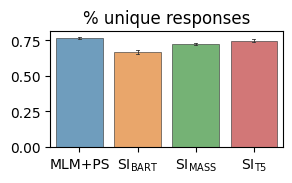

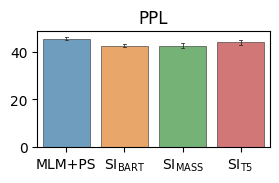

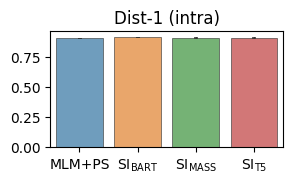

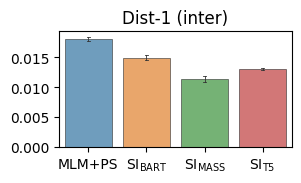

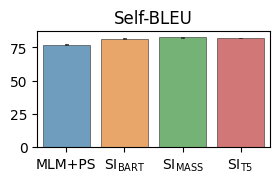

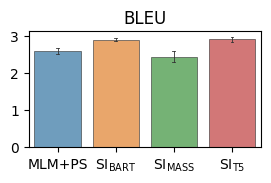

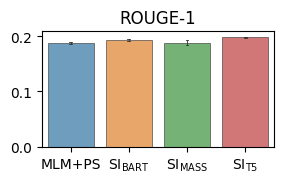

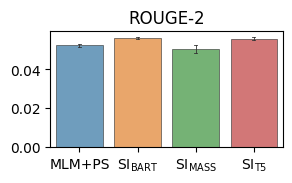

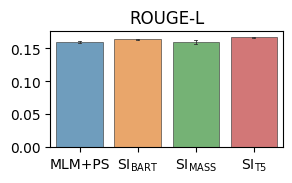

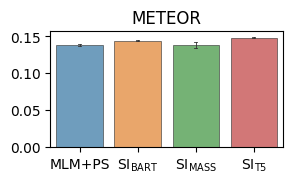

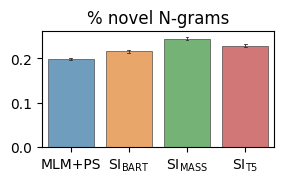

In [168]:
for metric in perf_metrics.keys():
    contrastive_model_barplot(df, ['MLM+PS','SI(BART)', 'SI(MASS)', 'SI(T5)'], 'xa_dialog', tgt_metric=metric, save_as="resources/plots/bart_small")

In [172]:
print(df['rouge1_t'].describe())
print(df['bleu_t'].describe())

count    2100.000000
mean        0.194511
std         0.032278
min         0.107041
25%         0.174681
50%         0.193963
75%         0.209613
max         0.287403
Name: rouge1_t, dtype: float64
count    2100.000000
mean        2.779046
std         1.386818
min         0.137027
25%         1.862241
50%         2.665552
75%         3.342370
max         7.198005
Name: bleu_t, dtype: float64


In [175]:
df[df['rouge1_t'] >= 0.28]

model_name_or_path  \
exp_seed model     gen_setting  chkpt ft_data_size seed                                            
23       bart_base xa_knowledge best  1.0          0       resources/models/seed_23/ft/bart_base   
                                                   42      resources/models/seed_23/ft/bart_base   
                                                   284     resources/models/seed_23/ft/bart_base   
                                                   983     resources/models/seed_23/ft/bart_base   
                                                   8630    resources/models/seed_23/ft/bart_base   
42       bart_base xa_knowledge best  1.0          0       resources/models/seed_42/ft/bart_base   
                                                   42      resources/models/seed_42/ft/bart_base   
                                                   284     resources/models/seed_42/ft/bart_base   
                                                   983     resources/models/seed_42/ft/bart_base   
                                                   8630    resources/models/seed_42/ft/bart_base   
1984     bart_base xa_knowledge best  1.0          0     resources/models/seed_1984/ft/bart_base   
                                                   42    resources/models/seed_1984/ft/bart_base   
                                                   284   resources/models/seed_1984/ft/bart_base   
                                                   983   resources/models/seed_1984/ft/bart_base   
                                                   8630  resources/models/seed_1984/ft/bart_base   

                                                         checkpoint_dir  \
exp_seed model     gen_setting  chkpt ft_data_size seed                   
23       bart_base xa_knowledge best  1.0          0                NaN   
                                                   42               NaN   
                                                   284              NaN   
                                                   983              NaN   
                                                   8630             NaN   
42       bart_base xa_knowledge best  1.0          0                NaN   
                                                   42               NaN   
                                                   284              NaN   
                                                   983              NaN   
                                                   8630             NaN   
1984     bart_base xa_knowledge best  1.0          0                NaN   
                                                   42               NaN   
                                                   284              NaN   
                                                   983              NaN   
                                                   8630             NaN   

                                                         batch_size  \
exp_seed model     gen_setting  chkpt ft_data_size seed               
23       bart_base xa_knowledge best  1.0          0            120   
                                                   42           120   
                                                   284          120   
                                                   983          120   
                                                   8630         120   
42       bart_base xa_knowledge best  1.0          0            120   
                                                   42           120   
                                                   284          120   
                                                   983          120   
                                                   8630         120   
1984     bart_base xa_knowledge best  1.0          0            120   
                                                   42           120   
                                                   284          120   
                                    

---

# Validation inference runs


In [14]:
df = get_all_results([23, 42, 1984], results_dir='results_topchat_kgd_valid_freq', build_dataframe=True)
get_detailed_info_on_complex_dataframe(df)


Found 36 models for seed 23: ['bart_small-SI_mass-squad_v2', 'bart_small-SI_bart5_50', 'bart_small-SI_t5-squad', 'scratch', 'bart_small-SI_bart', 'bart_small-SI_t5-0.25', 'bart_small-MLM', 'bart_small-SI_PS', 'bart_small-SI_t5-squad_v2', 'bart_small-SI_t5-enc-squad', 'bart_small-SI_bart5_75', 'bart_small-SI_mass-0.75', 'bart_base', 'bart_small-SI_mass-0.25', 'bart_small-PS', 'bart_small-SI_bart-enc-squad', 'bart_small-MLM_PS', 'bart_small-SI_bart-0.75', 'bart_small-SI_bart-squad_v2', 't5_small', 't5_lm_small', 'bart_small-SI_t5-0.5', 'bart_small-SI_t5-0.75', 'bart_small-SI_mass-enc-squad', 'bart_small-MLM_PS_DR', 'bart_small-SI_mass-0.5', 'bart_small-SI_t5', 'bart_small-SI_mass-0.1', 'bart_small-SI_t5-0.1', 'bart_small-SI_bart-0.5', 'bart_small-SI_mass-squad', 'bart_small-SI_bart5_25', 'bart_small-SI_bart-0.25', 'bart_small-SI_bart-0.1', 'bart_small-SI_mass', 'bart_small-SI_bart-squad']
Found 90 results files in corresponding results directory (resources/models/seed_23/results_topchat

In [15]:
df.head(8)

model_name_or_path  \
exp_seed model    gen_setting chkpt ft_data_size seed                                                   
23       SI(BART) default     7260  1.0          0     resources/models/seed_23/ft/bart_small-SI_bart   
                                                 42    resources/models/seed_23/ft/bart_small-SI_bart   
                                                 284   resources/models/seed_23/ft/bart_small-SI_bart   
                                                 983   resources/models/seed_23/ft/bart_small-SI_bart   
                                                 8630  resources/models/seed_23/ft/bart_small-SI_bart   
                              14520 1.0          0     resources/models/seed_23/ft/bart_small-SI_bart   
                                                 42    resources/models/seed_23/ft/bart_small-SI_bart   
                                                 284   resources/models/seed_23/ft/bart_small-SI_bart   

                                                         checkpoint_dir  \
exp_seed model    gen_setting chkpt ft_data_size seed                     
23       SI(BART) default     7260  1.0          0      checkpoint-7260   
                                                 42     checkpoint-7260   
                                                 284    checkpoint-7260   
                                                 983    checkpoint-7260   
                                                 8630   checkpoint-7260   
                              14520 1.0          0     checkpoint-14520   
                                                 42    checkpoint-14520   
                                                 284   checkpoint-14520   

                                                       batch_size  \
exp_seed model    gen_setting chkpt ft_data_size seed               
23       SI(BART) default     7260  1.0          0            120   
                                                 42           120   
                                                 284          120   
                                                 983          120   
                                                 8630         120   
                              14520 1.0          0            120   
                                                 42           120   
                                                 284          120   

                                                                                             test_file  \
exp_seed model    gen_setting chkpt ft_data_size seed                                                    
23       SI(BART) default     7260  1.0          0     resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 42    resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 284   resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 983   resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 8630  resources/data/Topical-Chat/KGD/valid_freq.json   
                              14520 1.0          0     resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 42    resources/data/Topical-Chat/KGD/valid_freq.json   
                                                 284   resources/data/Topical-Chat/KGD/valid_freq.json   

                                                       data_seed  \
exp_seed model    gen_setting chkpt ft_data_size seed              
23       SI(BART) default     7260  1.0          0             0   
                                                 42            0   
                                                 284           0   
                                                 983           0   
                                                 8630          0   
                              14520 1.0          0   

Dataframe has length: 1350
90
60


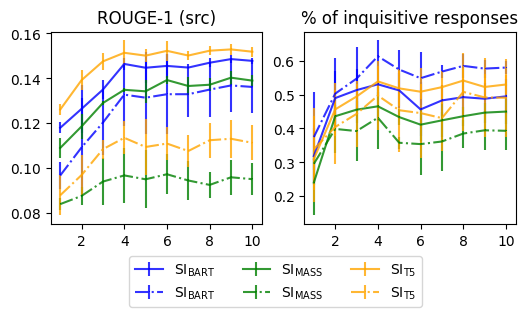

In [16]:
# plt.style.use('classic')
# plt.rcParams.update('IPython_default')
# sns.set_theme()
# sns.set_style("white")

def convert_steps_to_epochs(steps: List[int], max_epochs: int = 10) -> List[int]:
    if len(steps) == max_epochs:
        return list(range(1, max_epochs+1))
    else:
        raise NotImplementedError

def plot_validation_scores_ablation(df, agg_ops={}, gen_settings_subset=None, models_subset=None, save_as=None, verbose=False):

    styles = {
        'SI(BART)': 'b',
        'SI(T5)': 'orange',
        'SI(MASS)': 'g',
        'default': '-',
        'qu_ctxt_aug1': '--',
        'qu_ctxt_aug5': '-.',
    }
    
    line_styles = ['-', '--', '-.']
    colors = ['b', 'orange', 'g']
    
    group_by_cols = ['model', 'gen_setting', 'chkpt']
    
    if verbose:
        print(f'INDEX COLUMNS: {df.index.names}')
        print(f'GROUPING BY: {group_by_cols}')
        
    df = df.groupby(group_by_cols, as_index=True).agg(agg_ops)
    print(len(df))
    # subset
    df = df.iloc[df.index.get_level_values('gen_setting').isin(gen_settings_subset)]
    df = df.iloc[df.index.get_level_values('model').isin(models_subset)]
    print(len(df))
    
    # initialize figure
    fig, axes = plt.subplots(nrows=1, ncols=len(agg_ops), figsize=(3*len(agg_ops), 2.5), sharex=True)

    if len(agg_ops) == 1: # non-iterable axes version
        print('plotting non-iterable')
        for model_idx, (model, dfs) in enumerate(df.groupby(['model', 'gen_setting'])):
            for metric_index, metric in enumerate(agg_ops.keys()):
                if verbose:
                    print(f'Plotting {model} {metric} on axis {metric_index} ...')

                x_vals = convert_steps_to_epochs(list(dfs.index.get_level_values('chkpt').values), 10)
                # print(x_vals)
                axes.errorbar(
                    x_vals, 
                    dfs[metric]['mean'].values,
                    yerr=dfs[metric]['std'].values,
                    label = name_mapping.get(model[0], model[0]),
                    marker = 'o',
                    alpha = 0.8,
                    linestyle = styles[model[1]],
                    color = styles[model[0]],
                    # fmt='-o'
                )

                axes.set_title(f'{name_mapping.get(metric, metric)}')
                axes.set_xticks(x_vals)
                ax.set_xticklabels(x_vals, rotation=45)
                axes.legend(frameon=False)
    
    else:
        for model_idx, (model, dfs) in enumerate(df.groupby(['model', 'gen_setting'])):
            for metric_index, (ax, metric) in enumerate(zip(axes, agg_ops.keys())):
                if verbose:
                    print(f'Plotting {model} {metric} on axis {metric_index}...')

                x_vals = convert_steps_to_epochs(list(dfs.index.get_level_values('chkpt').values), 10)
                # print(x_vals)
                ax.errorbar(
                    x_vals, 
                    dfs[metric]['mean'].values,
                    yerr=dfs[metric]['std'].values,
                    label = name_mapping.get(model[0], model[0]) if metric_index == 0 else None,
                    marker = ',',
                    alpha = 0.8,
                    linestyle = styles[model[1]],
                    color = styles[model[0]],
                    )

                ax.set_title(f'{name_mapping.get(metric, metric)}')
                ax.set_xticks(x_vals[1::2])
                ax.set_xticklabels(x_vals[1::2], minor=False, rotation=0)
        # ax.legend(frameon=False)
    
    lgd = fig.legend(
        bbox_to_anchor=(0.5, -0.12), 
        loc='center',
        ncol=len(models_subset)
    )
    # fig.tight_layout()
    # plt.suptitle(f'Model checkpoint performance on validation set')
    
    if save_as is not None:
        plt.savefig(save_as+'.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
        plt.savefig(save_as+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    
    return

print(f'Dataframe has length: {len(df)}')
# plot_validation_scores_ablation(dfs, agg_ops={'bleu_t': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)'])
plot_validation_scores_ablation(
    df, 
    agg_ops={
        # 'ppl_mean':[np.mean, np.std],
        # 'bleu_t': [np.mean, np.std], 
        'rouge1_s': [np.mean, np.std],
        'qc_turn_level': [np.mean, np.std],
        }, 
    gen_settings_subset=['default', 'qu_ctxt_aug5'], 
    models_subset=[
        'SI(T5)',
        'SI(BART)',
        'SI(MASS)',
    ],
    save_as='resources/plots/epoch_validation_metrics',
    verbose=False
)


In [100]:
def coin_flip(prob_heads=0.5):
    """
    Returns True with probability prob_heads, False with probability 1-prob_heads.
    """
    turn = np.random.uniform(0,1)
    return True if turn <= prob_heads else False

results = Counter((coin_flip(0.25) for _ in range(1000)))
print(results)

Counter({False: 738, True: 262})


## Ablations - Fine-tuning dataset size

Dataframe has length: 3386


KeyError: 'std'

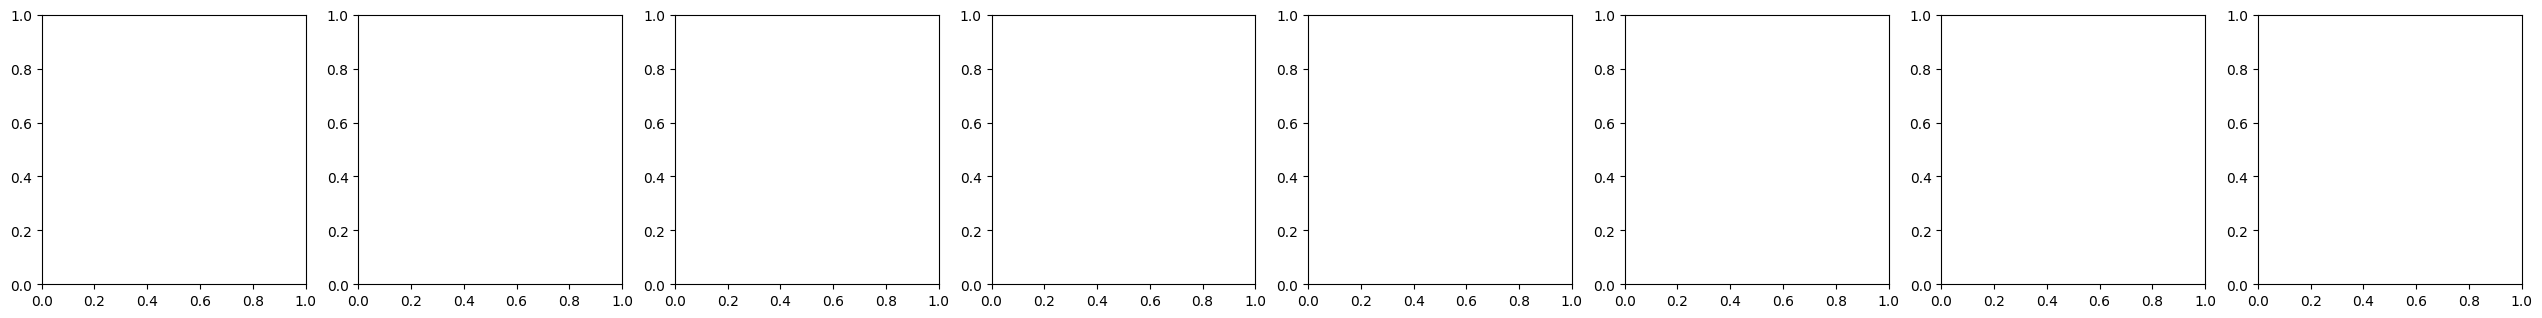

In [37]:
def plot_data_size_ablation(df, agg_ops={}, gen_settings_subset=None, models_subset=None, verbose=False):
    
    group_by_cols = ['model', 'gen_setting', 'ft_data_size']
    if verbose:
        print(f'INDEX COLUMNS: {df.index.names}')
        print(f'GROUPING BY: {group_by_cols}')
        
    dfa = df.groupby(group_by_cols, as_index=True).agg(agg_ops)
    
    # subset
    dfs = dfa.iloc[dfa.index.get_level_values('gen_setting').isin(gen_settings_subset)]
    dfs = dfs.iloc[dfs.index.get_level_values('model').isin(models_subset)]

    # initialize figure
    fig, axes = plt.subplots(nrows=1, ncols=len(agg_ops), figsize=(4*len(agg_ops), 3.5), sharex=True)

    if len(agg_ops) == 1: # non-iterable axes version
        for model, df in dfs.groupby(['model', 'gen_setting']):
            for k in agg_ops.keys():
                if verbose:
                    print(f'Plotting {model} {k} on axis {i} ...')

                x_vals = df.index.get_level_values('ft_data_size').values
                axes.errorbar(
                        x_vals, 
                        df[k]['mean'].values,
                        yerr=df[k]['std'].values,
                        label = model[0], # ' '.join(list(model)),
                        marker = 'o',
                        alpha=0.8,
                        linestyle = '-',
                        # fmt='-o'
                    )

                axes.set_title(f'{k}')
                axes.set_xticks(x_vals)
                axes.legend(frameon=False)
    
    else:
        for model, df in dfs.groupby(['model', 'gen_setting']):
            for ax, k in zip(axes, agg_ops.keys()):
                if verbose:
                    print(f'Plotting {model} {k} on axis {i} ...')

                x_vals = df.index.get_level_values('ft_data_size').values
                ax.errorbar(
                        x_vals, 
                        df[k]['mean'].values,
                        yerr=df[k]['std'].values,
                        label = model[0], # ' '.join(list(model)),
                        marker = 'o',
                        alpha=0.8,
                        linestyle = '-',
                        # fmt='-o'
                    )

                ax.set_title(f'{k}')
                ax.set_xticks(x_vals)
                ax.legend(frameon=False)

    plt.suptitle(f'Generation setting: {", ".join(gen_settings_subset)}')
    
    return

print(f'Dataframe has length: {len(df)}')
# plot_data_size_ablation(df, agg_ops=agg_ops, subset=['default', 'xa_dialog', 'xa_knowledge'])
# plot_data_size_ablation(df, agg_ops={'bleu_t': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['xa_dialog'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'ppl_mean': [np.mean, np.std]}, gen_settings_subset=['xa_knowledge'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])
# plot_data_size_ablation(df, agg_ops={'bleu_t': [np.mean, np.std], 'bleu_k': [np.mean, np.std], 'novelty_k_1gram': [np.mean, np.std]}, gen_settings_subset=['default'], models_subset=['SI(T5)','SI(MASS)','SI(BART)'])

plot_data_size_ablation(
    df, 
    agg_ops={
        # 'ppl_mean': [np.mean, np.std],
        # 'uniq': [np.mean, np.std],
        'bleu_t': [np.mean, np.std], 
        'rouge1_k': [np.mean, np.std],
        'rouge1_d': [np.mean, np.std],
        'novelty_k_1gram': [np.mean, np.std], 
        'novelty_d_1gram': [np.mean, np.std],
        'intra_dist1': [np.mean, np.std], 
        'inter_dist1': [np.mean, np.std],
        'qc_turn_level': [np.mean, np.std],
        }, 
    gen_settings_subset=['default'], 
    models_subset=['SI(T5)','SI(MASS)','SI(BART)']
)

# plot_data_size_ablation(
#     df, 
#     agg_ops={
#         'ppl_mean': [np.mean, np.std],
#         'uniq': [np.mean, np.std],
#         'bleu_t': [np.mean, np.std], 
#         'rouge1_k': [np.mean, np.std],
#         'rouge1_d': [np.mean, np.std],
#         'novelty_k_1gram': [np.mean, np.std], 
#         'novelty_d_1gram': [np.mean, np.std],
#         'intra_dist1': [np.mean, np.std], 
#         'inter_dist1': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['xa_dialog'], 
#     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# )

# plot_data_size_ablation(
#     df, 
#     agg_ops={
#         'ppl_mean': [np.mean, np.std],
#         'uniq': [np.mean, np.std],
#         'bleu_t': [np.mean, np.std], 
#         'rouge1_k': [np.mean, np.std],
#         'rouge1_d': [np.mean, np.std],
#         'novelty_k_1gram': [np.mean, np.std], 
#         'novelty_d_1gram': [np.mean, np.std],
#         'intra_dist1': [np.mean, np.std], 
#         'inter_dist1': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['xa_knowledge'], 
#     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# )

# plot_data_size_ablation(
#     df, 
#     agg_ops={
#         'ppl_mean': [np.mean, np.std],
#         'uniq': [np.mean, np.std],
#         'bleu_t': [np.mean, np.std], 
#         'rouge1_k': [np.mean, np.std],
#         'rouge1_d': [np.mean, np.std],
#         'novelty_k_1gram': [np.mean, np.std], 
#         'novelty_d_1gram': [np.mean, np.std],
#         'intra_dist1': [np.mean, np.std], 
#         'inter_dist1': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['xa_dialog+qu_ctxt_aug5'], 
#     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# )

# plot_data_size_ablation(
#     df, 
#     agg_ops={
#         'ppl_mean': [np.mean, np.std],
#         'uniq': [np.mean, np.std],
#         'bleu_t': [np.mean, np.std], 
#         'rouge1_k': [np.mean, np.std],
#         'rouge1_d': [np.mean, np.std],
#         'novelty_k_1gram': [np.mean, np.std], 
#         'novelty_d_1gram': [np.mean, np.std],
#         'intra_dist1': [np.mean, np.std], 
#         'inter_dist1': [np.mean, np.std],
#         }, 
#     gen_settings_subset=['xa_knowledge+qu_ctxt_aug5'], 
#     models_subset=['SI(T5)','SI(MASS)','SI(BART)']
# )



In [40]:
# import matplotlib.colors as mcolors
# colors = [mcolors.to_hex(plt.cm.tab20(i)) for i in range(20)]
# # patterns = ['', '\\', '+', 'x', '.', '*', 'o', 'O',]
# hpatterns = ['', '\\', '\\\\', '/', '//', '|', '||'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]
# vpatterns = ['', '\\', '\\\\', '/', '//', '-', '--'] # , '+', 'x', 'x', '.', '*', 'o', 'O',]

# def build_bar_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', horizontal: bool = False, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

#     # collect all the data for the relevant target metric first to set min and max vals for all plots
#     data = {}
#     for i, (model, dfx) in enumerate(df.groupby(level=0)):
#         model_results = {}
#         for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=1)):
#             metric_scores = dfx[target_metric].values
#             if min(metric_scores) < min_val:
#                 min_val = min(metric_scores)
#             if max(metric_scores) > max_val:
#                 max_val = max(metric_scores)
#             model_results[gen_setting] = metric_scores
#         data[model] = model_results

#     build_bar(data, horizontal=horizontal, verbose=verbose)
    
#     return


# def build_bar(data: Dict, horizontal: bool = True, verbose: bool = True):

#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#     positions = []
#     means = []
#     stds = []
#     bar_colors = []
#     bar_patterns = []
#     labels = []
    
#     pos = 0
#     for i, (model, gen_settings) in enumerate(data.items()):
#         # TODO make groups for colors and build legend
#         # https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
# #                 group = {model: {}}
#         for j, (gen_setting, scores) in enumerate(gen_settings.items()):

#             labels.append(f'{model} {gen_setting}')
            
#             if not horizontal:
#                 ax.bar(
#                     x = pos,
#                     height = scores.mean(),
#                     yerr=scores.std(), 
#                     color=colors[i],
#                     hatch=vpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             else:
#                 ax.barh(
#                     y = pos,
#                     width = scores.mean(),
#                     xerr=scores.std(), 
#                     color=colors[i],
#                     hatch=hpatterns[j],
#                     label=f'{model} {gen_setting}'
#                 )
            
#             pos += 1 # incrememt pos for next bar
        
#         if not horizontal:
#             ax.set_xticks(np.arange(len(labels)), labels=labels, rotation=45)
#         else:
#             ax.set_yticks(np.arange(len(labels)), labels=labels)
# #         ax.legend()
        
# dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)

# # dff = df.drop(labels=['bart_base', 't5_small', 'roberta_base'], axis=0, level=0, inplace=False)
# # build_bar_plots(dff, target_metric='qc_sent_level', horizontal=True, save=False, verbose=True)




In [ ]:
# agg_ops = {
#     'rouge1_t': np.mean,
#     'rougeL_t': np.mean,
#     'rouge1_k': np.mean,
#     'rougeL_k': np.mean,
#     'rouge1_d': np.mean,
#     'rougeL_d': np.mean,
#     'rouge1_s': np.mean,
#     'rougeL_s': np.mean,
#     'rougeL_s': np.mean,
#     'qc_turn_level': np.mean,
# }

# print(f'Dataframe has length: {len(df)}')
# dfs = df.iloc[df.index.get_level_values('ft_data_size') == 1.0] # select only those entries which use 100% fine-tuning data
# print(f'Dataframe has length: {len(dfs)}')
# dfa = aggregate_values_for_target_metric(dfs, agg_ops=agg_ops)
# dfa
# def plot_rouge(df):
#     df = df.stack().unstack(0)
#     # df = df.reset_index(level=1, drop=True) # re
#     return df
# dfp = plot_rouge(dfa)
# dfp

In [9]:
# OLD PLOTS

# def parse_title(title):
#     title = title.replace('bart_small', '')
#     title = title.replace('(denoising)', '')
#     title = title.replace('(denoising_t5)', 't5-style')
#     return title

# def build_violinplot(data: Dict, title: str, baseline_reference_data: Optional[Dict], min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))

#     if verbose:
#         print('Data:', data)

#     positions = range(1, len(data)+1)[::-1] # reveserse to have defualt at top
#     labels = list(data.keys())[::-1] # reveserse to have defualt at top
    
#     vp1 = ax.violinplot(
#         dataset = list(data.values()),
#         positions=positions,
#         points=30, widths=0.4,
#         showmeans=True, showextrema=True, showmedians=False,
#         vert=False,
#     )
#     if baseline_reference_data:
#         vp2 = ax.violinplot(
#             dataset = list(baseline_reference_data.values()),
#             positions=positions,
#             points=30, widths=0.4,
#             showmeans=True, showextrema=True, showmedians=False,
#             vert=False,
#         )

#         # create legend (currently v. rough)
#         # plt.legend([vp1['bodies'][0], vp2['bodies'][0]], [title, 'default'], loc=2)
        
#     # make title
#     ax.set_title(parse_title(title)) 
    
#     # label yaxis ticks
#     ax.yaxis.set_tick_params(direction='out') 
#     ax.yaxis.set_ticks_position('left')
#     ax.set_yticks(np.arange(1, len(labels) + 1), labels=labels)
# #     ax.set_ylabel('Generation setting')
    
#     # set xaxis limits
#     min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
#     max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
#     print(f'min={min_val}, max={max_val}')
#     ax.set_xlim(min_val, max_val) #, + 0.75)

#     return fig


# def build_violinplot_subfig(data: Dict, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = 0.0, max_val: float = 1.0, verbose: bool = False):
    
#     print('BASELINE model provided:', baseline_reference_key)
# #     baseline_reference_data = data.pop(baseline_reference_key) if baseline_reference_key is not None else None
#     baseline_reference_data = data.get(baseline_reference_key)
#     model_array = list(data.keys())
#     print(f'Plotting for models: {model_array}')
    
#     if len(model_array) <= 3:
#         # setup fig based on split arrays 1D
        
#         print('Building single row plots...')
#         nrows = 1
#         ncols = len(model_array)
#         fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
#         for i, model in enumerate(model_array):
            
#             model_results = data[model]

#             if baseline_reference_key is not None and baseline_reference_key != model:
#                 positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
#                 labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
#                 print(f'Plotting {model} on axes at position {i}')
#                 vp1 = axes[i].violinplot(
#                     dataset = list(data[model].values()),
#                     positions=positions,
#                     points=30, widths=0.4,
#                     showmeans=True, showextrema=True, showmedians=False,
#                     vert=False,
#                 )
#                 if baseline_reference_data:
#                     vp2 = axes[i].violinplot(
#                         dataset = list(baseline_reference_data.values()),
#                         positions=positions,
#                         points=30, widths=0.4,
#                         showmeans=True, showextrema=True, showmedians=False,
#                         vert=False,
#                     )
#                 # make title
#                 axes[i].set_title(parse_title(model))

#         # label yaxis ticks
#         axes[0].yaxis.set_tick_params(direction='out') 
#         axes[0].yaxis.set_ticks_position('left')
#         axes[0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
#     #     axes[0].set_ylabel('Generation setting')

#     #     # set xaxis limits
#         min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
#         max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
#         print(f'min={min_val}, max={max_val}')
#         axes[0].set_xlim(min_val, max_val) #, + 0.75)
    
#     else:
#         print('Building multi-row (2D) 3xN plots...')
#         # setup fig based on split arrays 2D
#         if len(model_array) <= 6:
#             nrows = 2
#         elif len(model_array) <= 9:
#             nrows = 3
#         elif len(model_array) <= 12:
#             nrows = 4
        
#         model_array = np.array_split(model_array, nrows)
#         ncols = max([len(a) for a in model_array])
#         fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), sharex=True, sharey=True)
#         for i, row in enumerate(model_array):
#             for j, model in enumerate(row):
# #                 if baseline_reference_key is not None and baseline_reference_key != model:
#                 positions = range(1, len(data[model])+1)[::-1] # reveserse to have defualt at top
#                 labels = list(data[model].keys())[::-1] # reveserse to have defualt at top
#                 print(f'Plotting {model} on axis at position {i}, {j}')
#                 vp1 = axes[i][j].violinplot(
#                     dataset = list(data[model].values()),
#                     positions=positions,
#                     points=30, widths=0.4,
#                     showmeans=True, showextrema=True, showmedians=False,
#                     vert=False,
#                 )
#                 if baseline_reference_data:
#                     vp2 = axes[i][j].violinplot(
#                         dataset = list(baseline_reference_data.values()),
#                         positions=positions,
#                         points=30, widths=0.4,
#                         showmeans=True, showextrema=True, showmedians=False,
#                         vert=False,
#                     )
#                 # make title
#                 axes[i][j].set_title(parse_title(model))

#             # label yaxis ticks
#             axes[0][0].yaxis.set_tick_params(direction='out') 
#             axes[0][0].yaxis.set_ticks_position('left')
#             axes[0][0].set_yticks(np.arange(1, len(labels) + 1), labels=labels)
#             # axes[0][0].set_ylabel('Generation setting')

#             # set xaxis limits
#             min_val = math.floor(min_val) # min_val-(max_val*0.1)) # x-axis margin = 10% of max value
#             max_val = math.ceil(max_val) #+(max_val*0.1)) # x-axis margin = 10% of max value
#             print(f'min={min_val}, max={max_val}')
#             axes[0][0].set_xlim(min_val, max_val) #, + 0.75)

#     plt.suptitle(target_metric)
#     plt.tight_layout()

#     return fig

# def build_violin_plots(df: pd.DataFrame, target_metric: str = 'qc_sent_level', baseline_reference_key: str = None, min_val: float = np.inf, max_val: float = -np.inf, save: bool = False, verbose: bool = False):

#     # collect all the data for the relevant target metric first to set min and max vals for all plots
#     data = {}
#     for i, (model, dfx) in enumerate(df.groupby(level=1)):
#         model_results = {}
#         for j, (gen_setting, dfx) in enumerate(dfx.groupby(level=2)):
#             metric_scores = dfx[target_metric].values
#             if min(metric_scores) < min_val:
#                 min_val = min(metric_scores)
#             if max(metric_scores) > max_val:
#                 max_val = max(metric_scores)
#             model_results[gen_setting] = metric_scores
#         data[model] = model_results

#     if verbose:
#         print('Data:')
#         print(data)
        
#     baseline_reference_data = data[baseline_reference_key] if baseline_reference_key is not None else None
    
#     # make violins for each model
#     for model, results in data.items():
#         if baseline_reference_key and baseline_reference_key != model:
#             fig = build_violinplot(results, f'{model} ({target_metric})', baseline_reference_data, min_val, max_val, verbose=verbose)
#             if save:
#                 outpath = str(plot_path / f'{model}-{target_metric}.png')
#                 fig.savefig(outpath, dpi='figure', bbox_inches='tight')
#                 print(f'saved {outpath}')
    
#     # make a subfig for all models
#     fig = build_violinplot_subfig(data, target_metric, baseline_reference_key, min_val, max_val, verbose=verbose)
#     if save:
#         outpath = str(plot_path / f'{baseline_reference_key}_vs_all-{target_metric}.png')
#         fig.savefig(outpath, dpi='figure', bbox_inches='tight')
#         print(f'saved {outpath}')
 
#     return

# # TODO: update!

# # compare bart_base with bart_small
# # dff = df[df.index.isin(['bart_base', 'bart_small(denoising)'], level=0)]
# # build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)

# # # # compare all bart_small models
# # dff = df.iloc[~df.index.get_level_values(1).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
# # print(len(dff))
# # dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=2, axis=0)
# # print(len(dff))
# # build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='MLM+PS', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='MLM+PS', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='MLM+PS', save=True, verbose=False)

# # # # # compare off-the-shelf fine-tuned models
# # dff = df.iloc[df.index.get_level_values(1).str.contains('_')] # https://stackoverflow.com/questions/34771090/pandas-dataframe-with-multiindex-check-if-string-is-contained-in-index-level
# # print(len(dff))
# # dff = dff.drop(['xa_dialog', 'xa_knowledge'], level=2, axis=0)
# # print(len(dff))
# # build_violin_plots(dff, target_metric='qc_sent_level', baseline_reference_key='bart_base', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_t', baseline_reference_key='bart_base', save=True, verbose=False)
# # build_violin_plots(dff, target_metric='bleu_k', baseline_reference_key='bart_base', save=True, verbose=False)

